In [1]:
# Calling the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

### 1- Business Problem

It is desired to develop a machine learning model that can predict whether people with specified characteristics have diabetes or not. It is expected that the necessary data pre-processing and feature engineering steps will be carried out before developing the model.

### 2- Dataset Story

It is a part of a large dataset maintained by the National Institute of Diabetes and Digestive and Kidney Diseases in the United States. The data is utilized for a diabetes study conducted on Pima Indian women aged 21 and above, residing in Phoenix, the fifth-largest city in the state of Arizona. The target variable is indicated as outcome, with 1 denoting a positive diabetes test result and 0 indicating a negative result.

### 3- Features

+ Pregnancies - Number of pregnancies
+ Glucose - Plasma glucose concentration at 2 hours in an oral glucose tolerance test
+ BloodPressure - Diastolic blood pressure (mmHg)
+ SkinThickness - Triceps skin fold thickness (mm)
+ Insulin - Two-hour serum insulin (μU/ml)
+ BMI - Body mass index (kg/m²)
+ DiabetesPedigreeFunction - Diabetes pedigree function
+ Age - Age (years)
+ Outcome - Presence of the disease (1) or absence (0)

### 4- Tasks

In [2]:
# Load the dataset
df = pd.read_csv("datasets/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


##### 4.1 Exploratory Data Analysis

In [3]:
# Examine the general picture.

def check_df(dataframe, head=5):
    print("########## Shape ##########", end="\n\n")
    print(dataframe.shape, end="\n\n\n")
    print("########## Types ##########", end="\n\n")
    print(dataframe.dtypes, end="\n\n\n")
    print("########## Head ##########", end="\n\n")
    print(dataframe.head(), end="\n\n\n")
    print("########## Tail ##########", end="\n\n")
    print(dataframe.tail(), end="\n\n\n")
    print("########## NA ##########", end="\n\n")
    print(dataframe.isnull().sum(), end="\n\n\n")
    print("########## Quantiles ##########", end="\n\n")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T, end="\n\n\n")


check_df(df)

########## Shape ##########

(768, 9)


########## Types ##########

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


########## Head ##########

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0 

In [4]:
# Capturing numeric and categorical variables

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

     It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
     Note: Categorical variables with numerical appearance are also included.

    Parameters
    ------
        dataframe: dataframe
                Dataframe from which variable names are to be taken
        cat_th: int, optional
                Class threshold value for variables that are numeric but categorical
        car_th: int, optinal
                class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numerical variable list
        cat_but_car: list
                List of cardinal variables with categorical view

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        inside num_but_cat cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [5]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [6]:
cat_cols

['Outcome']

In [7]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [8]:
cat_but_car

[]

In [9]:
# Analyze numerical and categorical variables.

In [10]:
###################################
# ANALYSIS OF CATEGORICAL VARIABLES
###################################

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
          "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

         Outcome      Ratio
Outcome                    
0            500  65.104167
1            268  34.895833
################


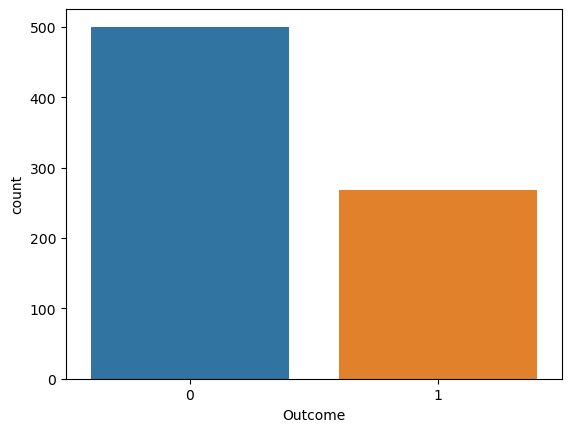

In [11]:
cat_summary(df, "Outcome", True)

In [12]:
###################################
# ANALYSIS OF NUMERICAL VARIABLES
##################################

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)


count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


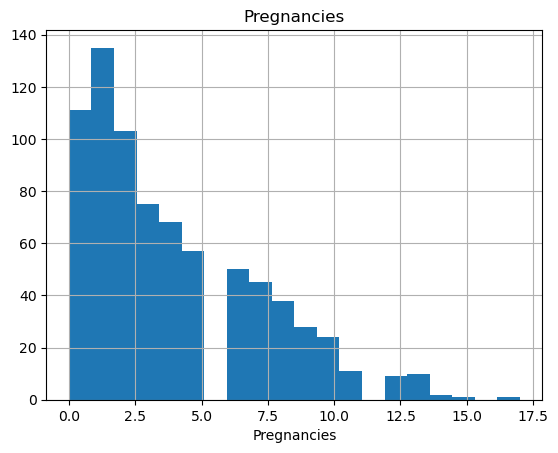

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


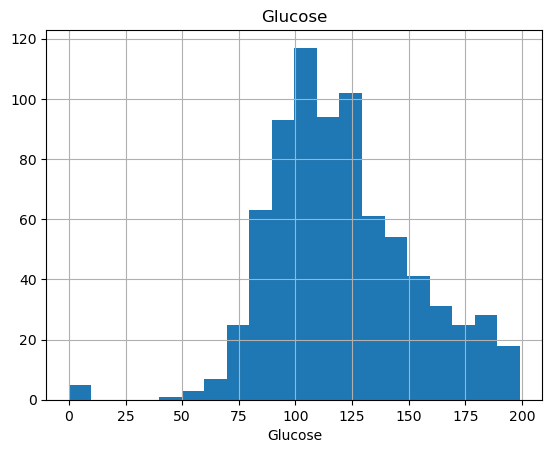

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


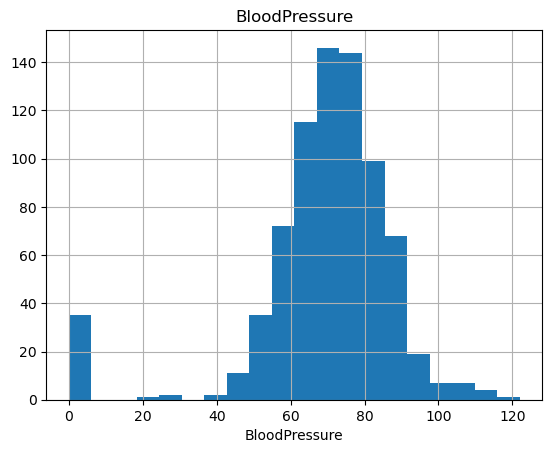

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64


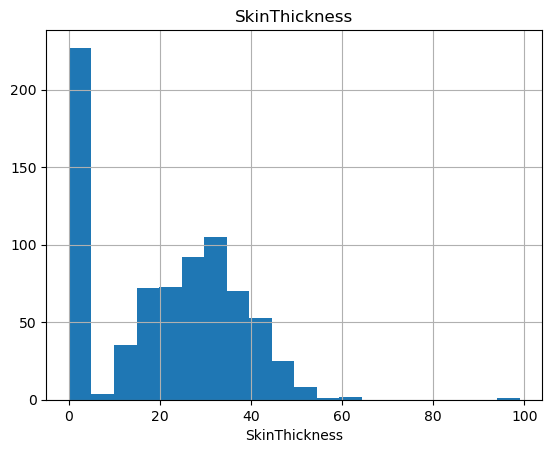

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64


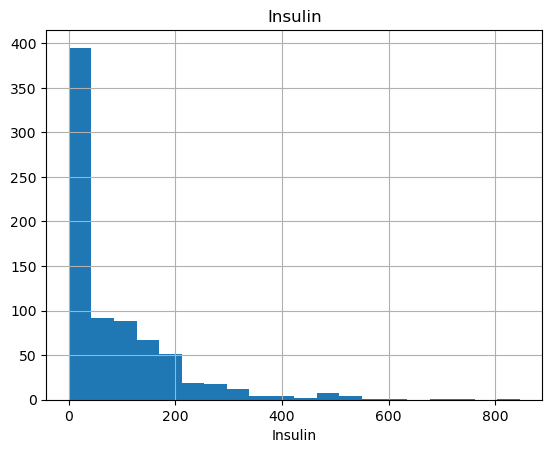

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


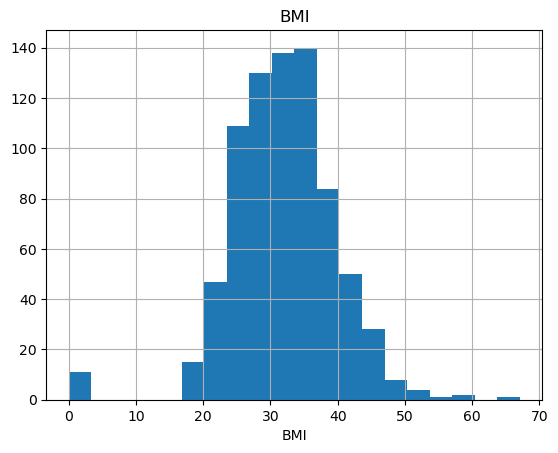

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


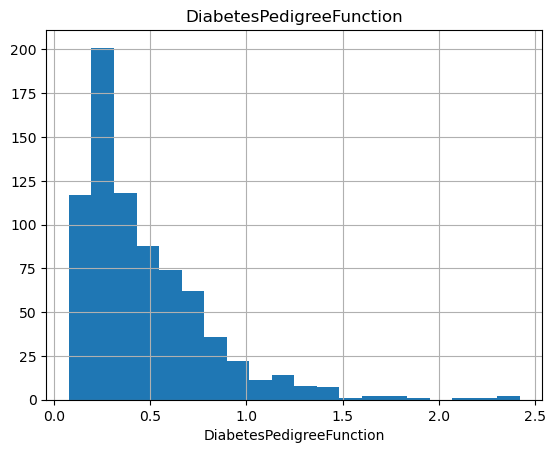

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


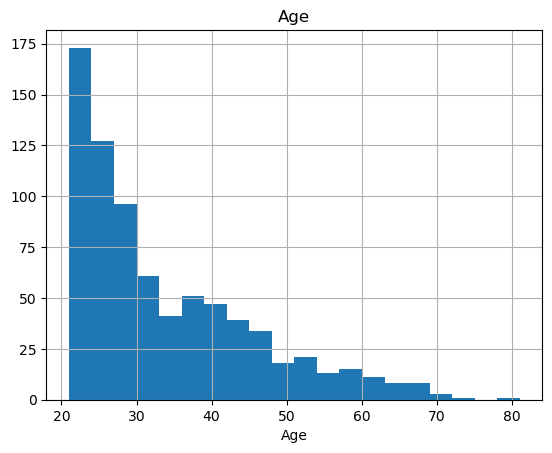

In [13]:
for col in num_cols:
    num_summary(df, col, True)

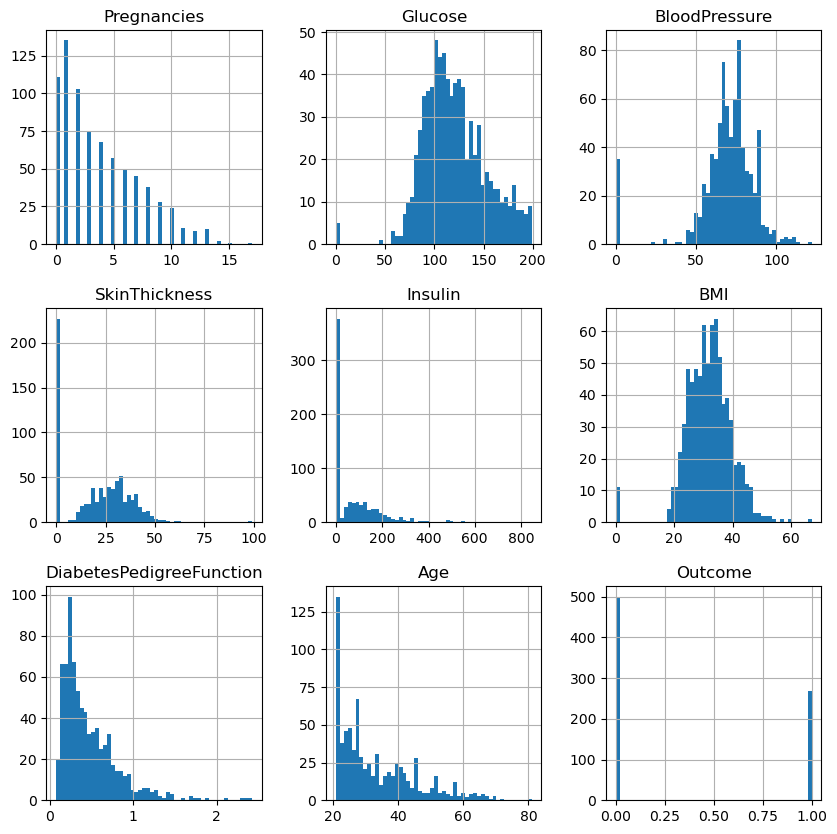

In [14]:
%matplotlib inline
df.hist(bins=50, figsize=(10,10))
plt.show()

In [15]:
# Conduct target variable analysis.

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




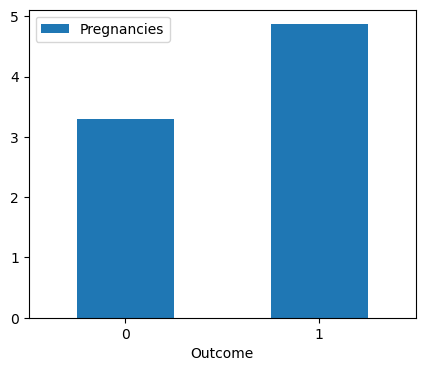

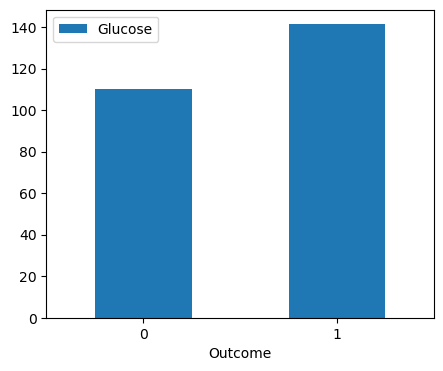

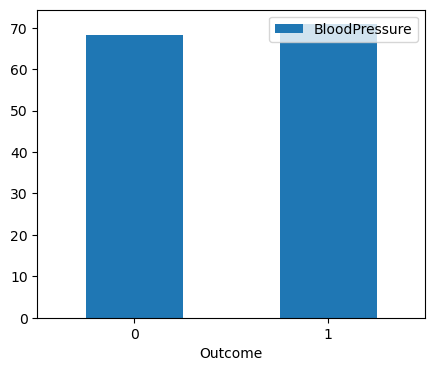

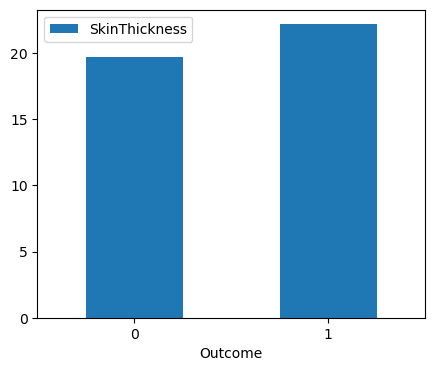

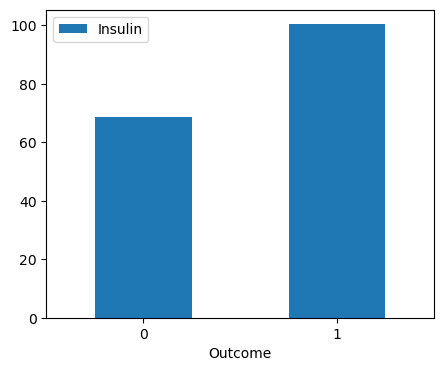

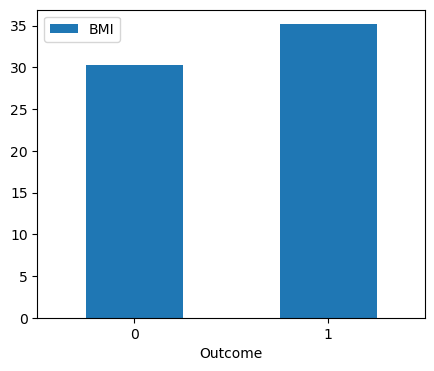

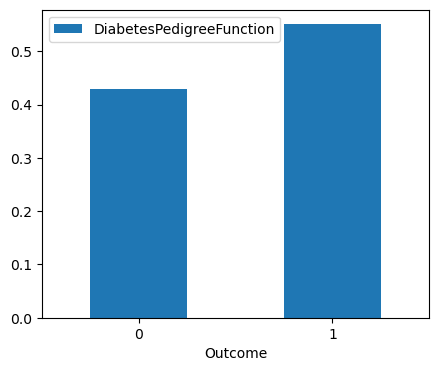

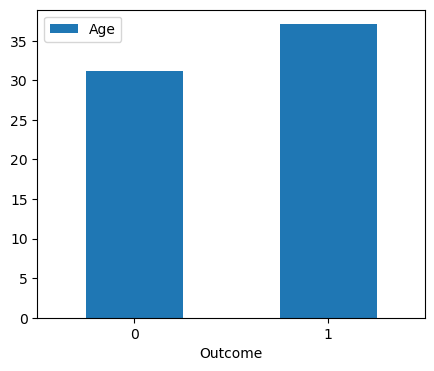

In [16]:
# Graphical representation according to target variable
for col in num_cols:
    df.groupby('Outcome').agg({col: 'mean'}).plot(kind='bar', rot=0, figsize=(5,4))

###### 4.1.1 Outliers Analysis

In [17]:
# Conduct an outlier observation analysis.
## First, the threshold value (threshold), upper and lower limits are determined.

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [18]:
## Then we questioned whether there were any outliers

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None):
        return True
    else:
        return False

In [19]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies True
Glucose True
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True


In [20]:
# Suppression of found outliers

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    replace_with_thresholds(df, col)

In [21]:
# If we want to check if there are still outliers after suppressing;

for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


###### 4.1.2 The Missing Values Analysis

In [22]:
# There are no missing observations in the data set, but Glucose, Insulin etc. Observation units containing 0 values in variables may represent missing values. 
# For example; A person's glucose or insulin value will not be 0. Considering this situation, you can assign zero values as NaN in the relevant values and then apply the operations to the missing values.

In [23]:
# First, we select variables that contain zero. Except for pregnancies and outcome
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

In [24]:
# Then we need to replace the variable observations containing zero with NaN
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

In [25]:
# To find missing observations

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


na_cols = missing_values_table(df, na_name=True)

               n_miss  ratio
Insulin           374  48.70
SkinThickness     227  29.56


In [26]:
# Examining missing values with the dependent variable

def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + "_NA_FLAG"] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "COUNT": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df,"Outcome", na_cols)

                       TARGET_MEAN  COUNT
SkinThickness_NA_FLAG                    
0                         0.332717    541
1                         0.387665    227


                 TARGET_MEAN  COUNT
Insulin_NA_FLAG                    
0                   0.329949    394
1                   0.368984    374




In [27]:
# Filling missing data with median

for col in num_cols:
    if col != 'PREGNANCIES':
        df[col].fillna(df.groupby(cat_cols)[col].transform('median'), inplace=True)

In [28]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


###### 4.1.3 Correlation Analysis

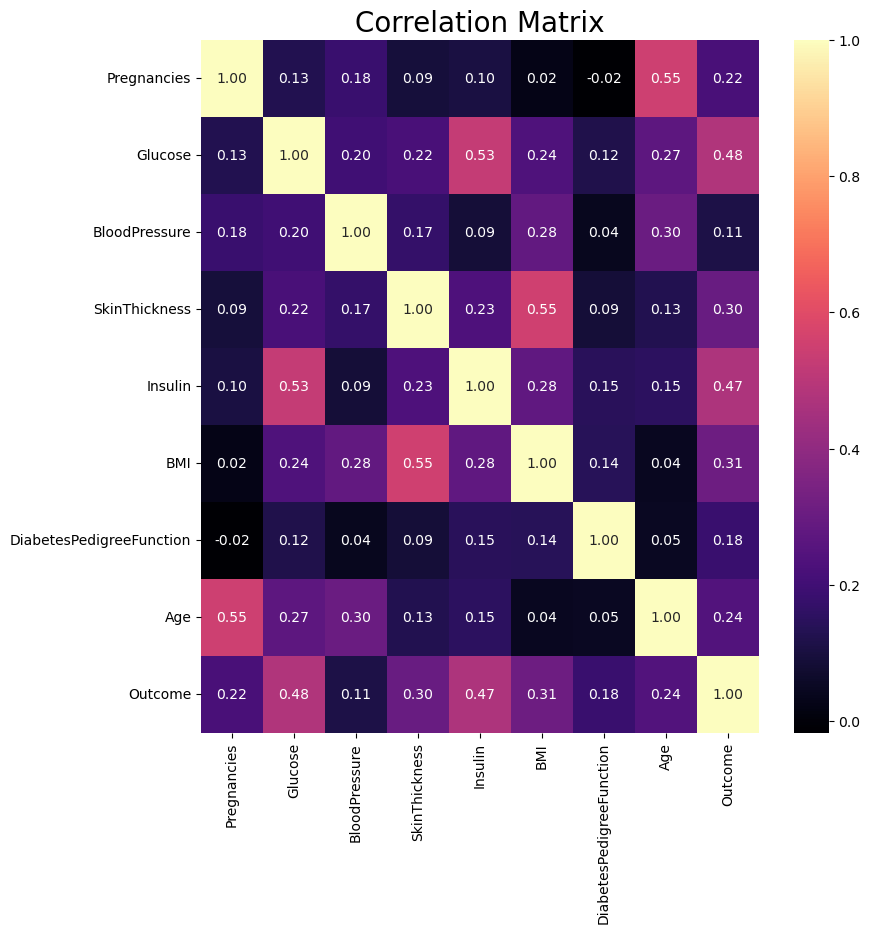

In [29]:
df[num_cols].corr()
f, ax = plt.subplots(figsize=[9,9])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

##### 4.2 Feature Engineering

###### 4.2.1 Create new variables.

In [30]:
# Creating a new variable using the age variable

df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"
df["NEW_AGE_CAT"].head()

0    senior
1    mature
2    mature
3    mature
4    mature
Name: NEW_AGE_CAT, dtype: object

In [31]:
# BMI below 18.5 is underweight, between 18.5 and 24.9 is normal, between 24.9 and 29.9 is overweight, and above 30 is obese.

df['NEW_BMI'] = pd.cut(df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100], labels=["Underweight", "Healthy", "Overweight", "Obese"])
df['NEW_BMI'].head()

0         Obese
1    Overweight
2       Healthy
3    Overweight
4         Obese
Name: NEW_BMI, dtype: category
Categories (4, object): ['Underweight' < 'Healthy' < 'Overweight' < 'Obese']

In [32]:
# Converting glucose value to categorical variable

df["NEW_GLUCOSE"] = pd.cut(df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])
df["NEW_GLUCOSE"].head()

0    Prediabetes
1         Normal
2    Prediabetes
3         Normal
4         Normal
Name: NEW_GLUCOSE, dtype: category
Categories (3, object): ['Normal' < 'Prediabetes' < 'Diabetes']

In [33]:
# Creating a categorical variable from insulin variable

def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"  
    
df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)    
df["NEW_INSULIN_SCORE"].head()

0    Abnormal
1      Normal
2    Abnormal
3      Normal
4    Abnormal
Name: NEW_INSULIN_SCORE, dtype: object

In [34]:
df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]

df["NEW_GLUCOSE_PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]

In [35]:
# Since we added new variables, grab_col_names is called again

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 15
cat_cols: 5
num_cols: 10
cat_but_car: 0
num_but_cat: 3


###### 4.2.2 Encoding Operations

In [36]:
# Label Encoder

def label_encoder(dataframe, binary_col):
    label_encoder = LabelEncoder()
    dataframe[binary_col] = label_encoder.fit_transform(dataframe[binary_col])
    return dataframe


binary_col = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]


for col in binary_col:
    label_encoder(df, col)

In [37]:
# One-hot Encoder

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dtype=int)
    return dataframe


cat_cols = [col for col in cat_cols if col not in binary_col and col not in ["Outcome"]]

df = one_hot_encoder(df, cat_cols, drop_first=True)

###### 4.2.3 Standardize for numeric variables

In [38]:
ss = StandardScaler()
df[num_cols] = ss.fit_transform(df[num_cols])

In [39]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_GLUCOSE,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE_PREGNANCIES,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese
0,0.647150,0.861926,0.092691,0.680985,0.524765,0.209359,0.588927,1.445691,1,1,1,0,0.651996,0.895852,0,0,1
1,-0.848970,-1.159433,-0.330201,-0.007470,-0.512599,-0.784254,-0.378101,-0.189304,0,0,0,1,-0.752527,-0.859837,0,1,0
2,1.245598,1.984903,-0.471166,0.336757,0.524765,-1.252672,0.746595,-0.103252,1,0,1,0,1.160888,2.155226,1,0,0
3,-0.848970,-1.031093,-0.330201,-0.695925,-0.644205,-0.571337,-1.022787,-1.049828,0,0,0,1,-0.782250,-0.851092,0,1,0
4,-1.148194,0.508990,-2.162737,0.680985,0.501541,1.557835,2.596563,-0.017199,1,0,0,0,0.474431,-1.045682,0,0,1


##### 4.3 Modelling

In [40]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [42]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.8744588744588745

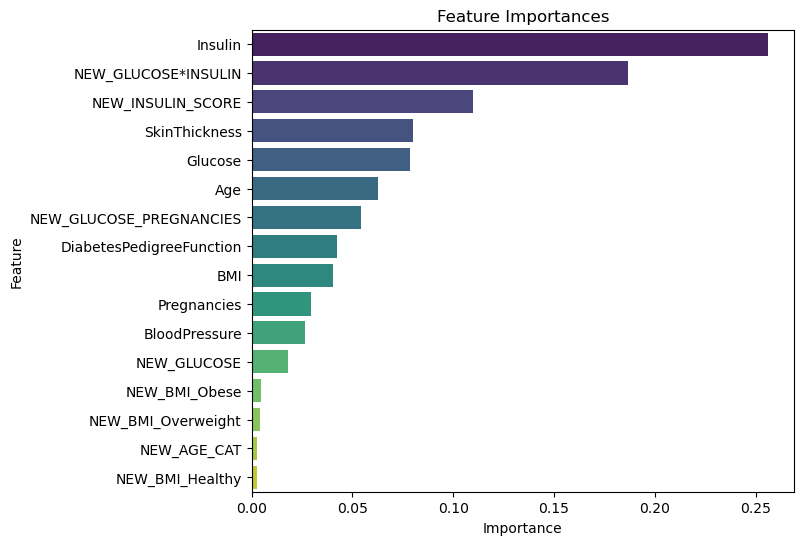

In [43]:
# Feature Importance

importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
importance = importance.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(7, 6))
# Visualize feature importances
sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')
plt.title('Feature Importances')
plt.show()

In [44]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression()
lr_model.fit(X_train , y_train)
y_pred=lr_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.8354978354978355